In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

In [3]:
dec_nofilter = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/DGDMRCorr/density/FINAL.nofilter.Intragenic.decrease.results.csv',
    index_col=0
)
dec_nofilter['length'] = dec_nofilter['end'] - dec_nofilter['start']
inc_nofilter = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/DGDMRCorr/density/FINAL.nofilter.Intragenic.increase.results.csv',
    index_col=0
)
inc_nofilter['length'] = inc_nofilter['end'] - inc_nofilter['start']

In [4]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_meta['length'] = gene_meta['end'] - gene_meta['start']
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

tf_genes = pd.read_csv(
    '/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv',
    index_col=0)
tf_genes = set(','.join(tf_genes['EnsemblID'].dropna()).split(','))
gene_meta['is_tf'] = gene_meta.index.map(lambda i: i.split('.')[0] in tf_genes)

zfp_pattern = r'Zfp\d+'
p = re.compile(zfp_pattern)
gene_meta.loc[gene_meta['gene_name'].apply(lambda i: p.search(i) is not None), 'is_tf'] = True
tf_gene_names = set(gene_meta[gene_meta['is_tf']]['gene_name'].tolist())

remove_gene_pattern = r'(Gm\d+)|(.+Rik)'
p = re.compile(remove_gene_pattern)

keep_gene = gene_meta[gene_meta['gene_name'].apply(lambda i: p.search(i) is None)].index

# per gene sig
per_gene_test = pd.read_csv('../usegenes.csv', header=None, index_col=1).index
keep_gene = keep_gene & per_gene_test
keep_gene.size

2522

## Decreasing DMR

In [5]:
data = dec_nofilter

In [6]:
def sig_level(row):
    adj_p = row['adj_p']
    n_dms = row['dms_in']
    if (adj_p < 0.01) & (n_dms > 30):
        return 'r'
    elif adj_p < 0.05:
        return 'g'
    else:
        return 'g'
data['judge'] = data.apply(sig_level, axis=1)

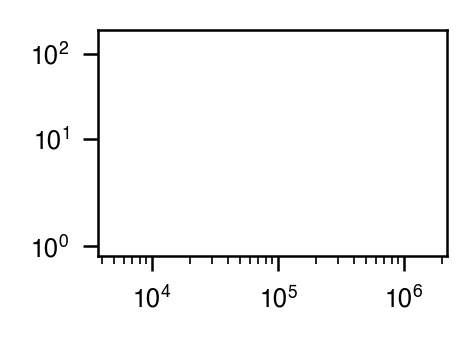

In [7]:
fig, ax = plt.subplots(figsize=(1.5, 1), dpi=300)

sns.scatterplot(ax=ax, data=data[data['length'] > 5000], 
                x='length', y='odds',
                s=1, linewidth=0, 
                hue='judge', palette={'r': 'red', 'k': 'k', 'g': 'lightgray'},
                # size='dms_in', sizes=(0, 20), size_norm=(0, 500),
                legend=False)
ax.set(xscale='log', yscale='symlog', xlabel='', ylabel='')

# for i in (np.log10(data['length']) + np.log10(data['odds'])).sort_values(ascending=False)[:10].index:
#     for gene in data.loc[i, 'gene_ids'].split(','):
#         if gene not in keep_gene:
#             continue
#         gene_name = gene_meta.loc[gene, 'gene_name']
#         ax.text(data.loc[i, 'length'], data.loc[i, 'odds'], gene_name, 
#                 fontsize=6)
# 

ax.collections[0].remove()

fig.savefig('decreasing_dmr_enriched_genes.label_part.pdf')

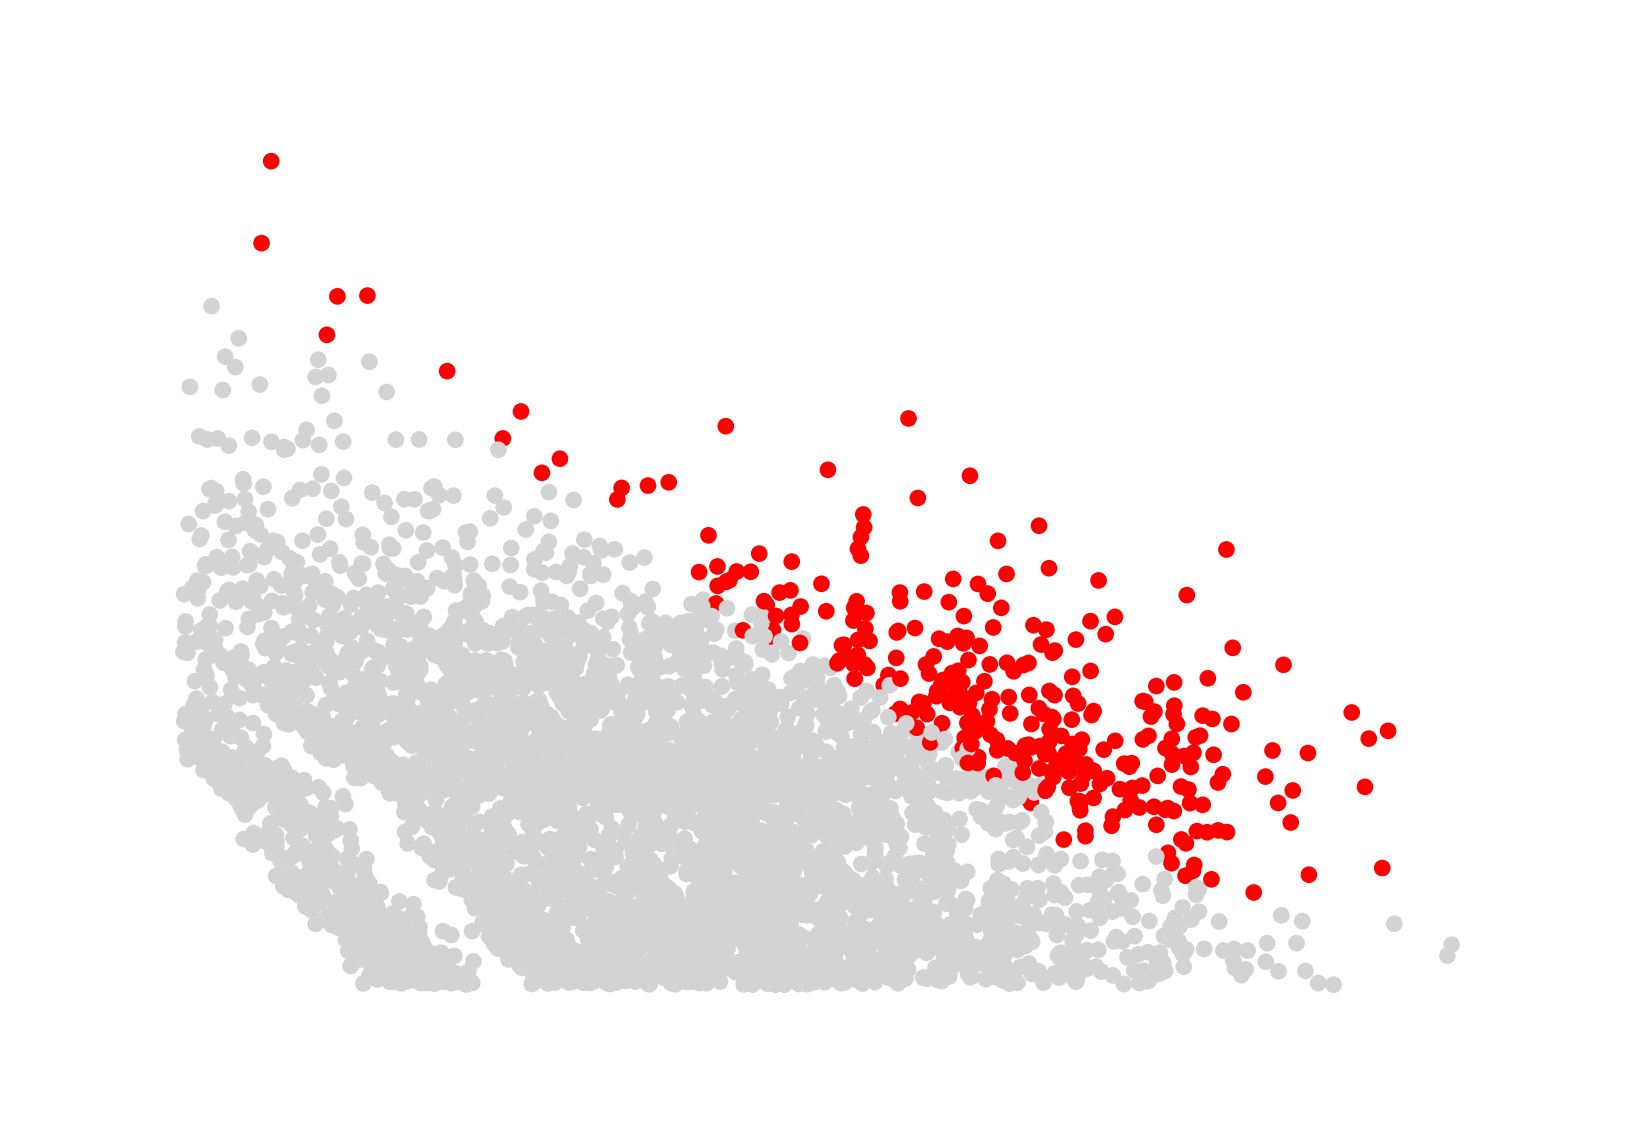

In [8]:
fig, ax = plt.subplots(figsize=(1.5, 1), dpi=1200)

sns.scatterplot(ax=ax, data=data[data['length'] > 5000], 
                x='length', y='odds',
                s=1, linewidth=0, 
                hue='judge', palette={'r': 'red', 'k': 'k', 'g': 'lightgray'},
                # size='dms_in', sizes=(0, 20), size_norm=(0, 500),
                legend=False)
ax.set(xscale='log', yscale='symlog', xlabel='', ylabel='')

# for i in (np.log10(data['length']) + np.log10(data['odds'])).sort_values(ascending=False)[:10].index:
#     for gene in data.loc[i, 'gene_ids'].split(','):
#         if gene not in keep_gene:
#             continue
#         gene_name = gene_meta.loc[gene, 'gene_name']
#         ax.text(data.loc[i, 'length'], data.loc[i, 'odds'], gene_name, 
#                 fontsize=6)
# 

ax.axis('off')

fig.savefig('decreasing_dmr_enriched_genes.scatter_part.png')

In [10]:
gene_names = set()
gene_ids = set()
for genes in data[data['judge'] == 'r']['gene_ids']:
    for gene in genes.split(','):
        if gene not in keep_gene:
            continue
        if gene_meta.loc[gene, 'length'] < 5000:
            continue
        gene_ids.add(gene)
        gene_name = gene_meta.loc[gene, 'gene_name']
        gene_names.add(gene_name)

with open('Decreasing_gene_ids.txt', 'w') as f:
    for gene in gene_ids:
        f.write(gene+'\n')

len(gene_names)

112

## Increasing DMR

In [11]:
data = inc_nofilter

In [12]:
def sig_level(row):
    adj_p = row['adj_p']
    n_dms = row['dms_in']
    if (adj_p < 0.01) & (n_dms > 30):
        return 'r'
    elif adj_p < 0.05:
        return 'g'
    else:
        return 'g'
data['judge'] = data.apply(sig_level, axis=1)

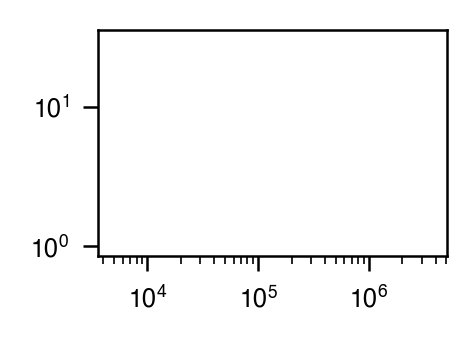

In [13]:
fig, ax = plt.subplots(figsize=(1.5, 1), dpi=300)

sns.scatterplot(ax=ax, data=data[data['length'] > 5000], 
                x='length', y='odds',
                s=1, linewidth=0, 
                hue='judge', palette={'r': 'red', 'k': 'k', 'g': 'lightgray'},
                # size='dms_in', sizes=(0, 20), size_norm=(0, 500),
                legend=False)
ax.set(xscale='log', yscale='symlog', xlabel='', ylabel='')

# for i in (np.log10(data['length']) + np.log10(data['odds'])).sort_values(ascending=False)[:10].index:
#     for gene in data.loc[i, 'gene_ids'].split(','):
#         if gene not in keep_gene:
#             continue
#         gene_name = gene_meta.loc[gene, 'gene_name']
#         ax.text(data.loc[i, 'length'], data.loc[i, 'odds'], gene_name, 
#                 fontsize=6)
# 

ax.collections[0].remove()

fig.savefig('increasing_dmr_enriched_genes.label_part.pdf')

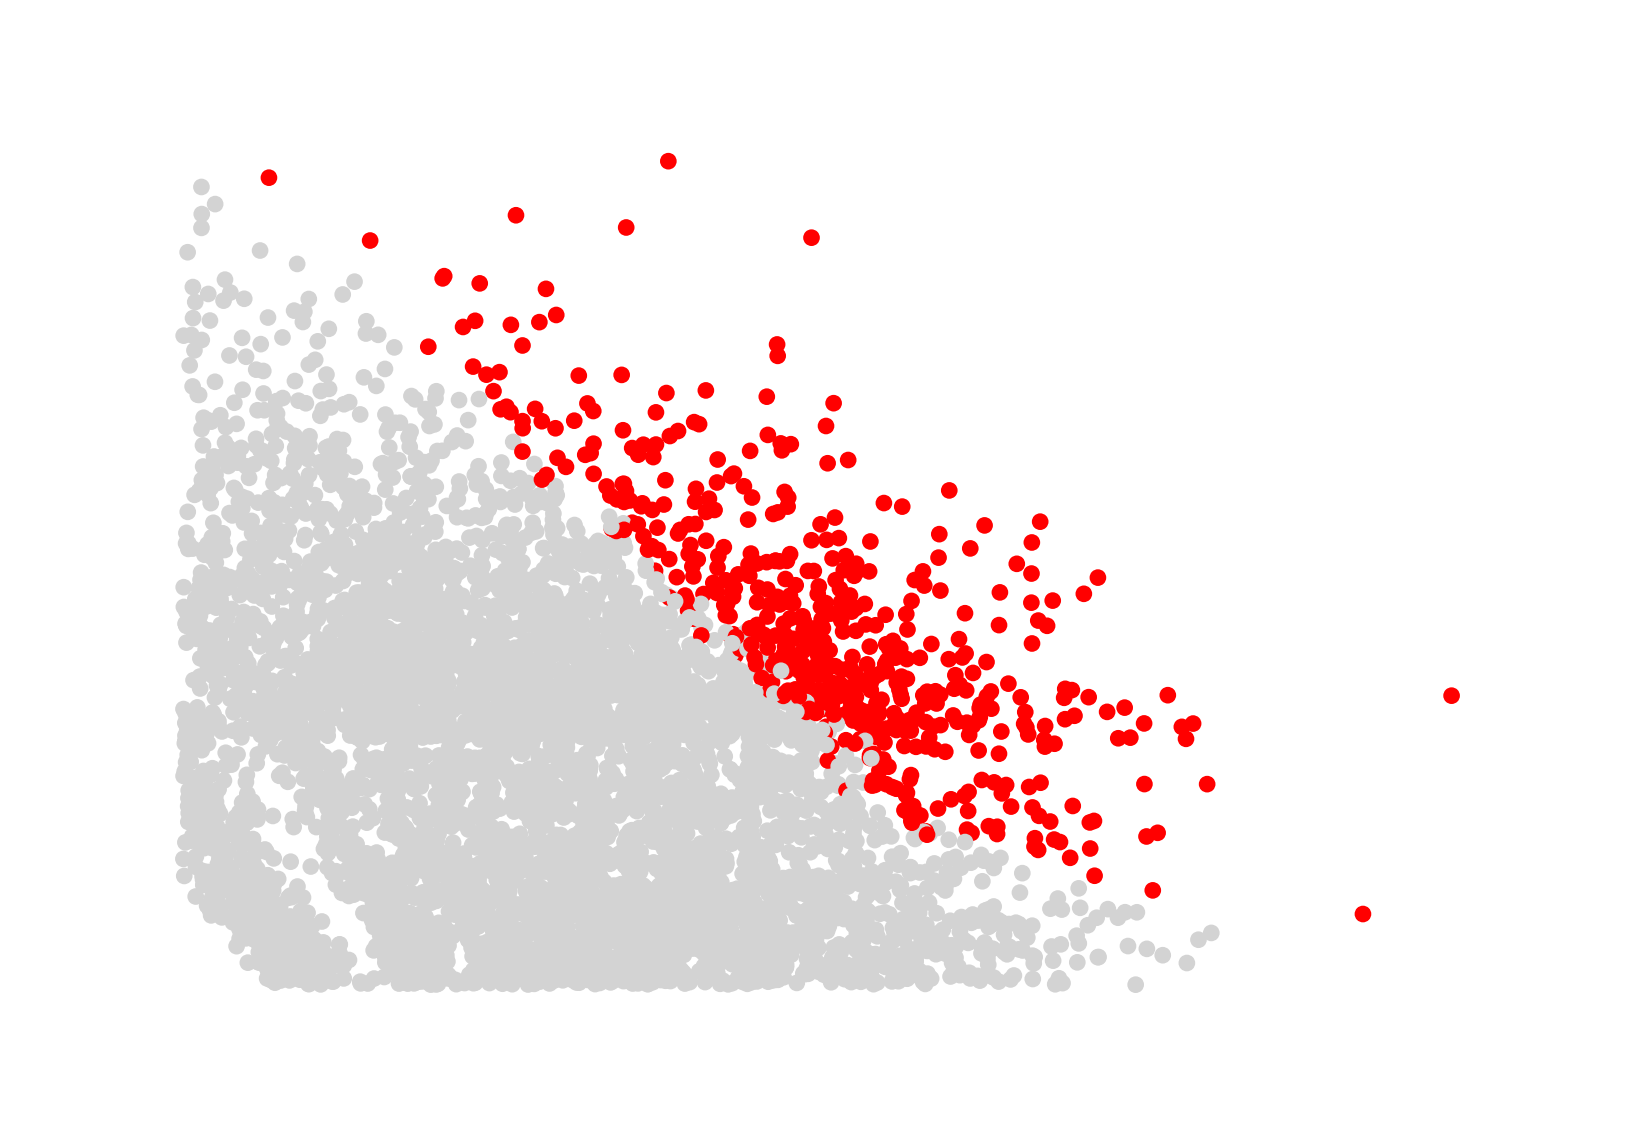

In [14]:
fig, ax = plt.subplots(figsize=(1.5, 1), dpi=1200)

sns.scatterplot(ax=ax, data=data[data['length'] > 5000], 
                x='length', y='odds',
                s=1, linewidth=0, 
                hue='judge', palette={'r': 'red', 'k': 'k', 'g': 'lightgray'},
                # size='dms_in', sizes=(0, 20), size_norm=(0, 500),
                legend=False)
ax.set(xscale='log', yscale='symlog', xlabel='', ylabel='')

# for i in (np.log10(data['length']) + np.log10(data['odds'])).sort_values(ascending=False)[:10].index:
#     for gene in data.loc[i, 'gene_ids'].split(','):
#         if gene not in keep_gene:
#             continue
#         gene_name = gene_meta.loc[gene, 'gene_name']
#         ax.text(data.loc[i, 'length'], data.loc[i, 'odds'], gene_name, 
#                 fontsize=6)
# 

ax.axis('off')

fig.savefig('increasing_dmr_enriched_genes.scatter_part.png')

[None, Text(0, 0.5, ''), None, Text(0.5, 0, '')]

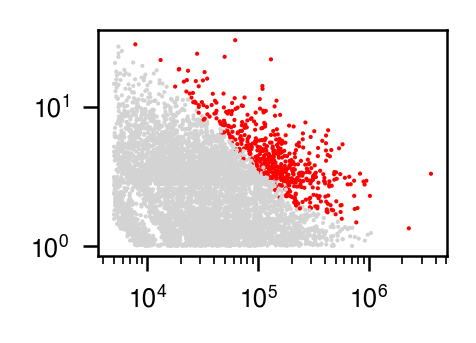

In [15]:
fig, ax = plt.subplots(figsize=(1.5, 1), dpi=300)

sns.scatterplot(ax=ax, data=data[data['length'] > 5000], 
                x='length', y='odds',
                s=1, linewidth=0, 
                hue='judge', palette={'r': 'red', 'k': 'k', 'g': 'lightgray'},
                # size='dms_in', sizes=(0, 20), size_norm=(0, 500),
                legend=False)
ax.set(xscale='log', yscale='symlog', xlabel='', ylabel='')


In [16]:
gene_names = set()
gene_ids = set()
for genes in data[data['judge'] == 'r']['gene_ids']:
    for gene in genes.split(','):
        if gene not in keep_gene:
            continue
        if gene_meta.loc[gene, 'length'] < 5000:
            continue
        gene_ids.add(gene)
        gene_name = gene_meta.loc[gene, 'gene_name']
        gene_names.add(gene_name)

with open('Increasing_gene_ids.txt', 'w') as f:
    for gene in gene_ids:
        f.write(gene+'\n')

len(gene_names)

328